# Introductory notebook

In this notebook we will compare linear regression with XGBoost in forecasting weakly stationary data. We will also show the impact of hyperparameter tuning XGBoost, and we will compare the computational complexity of Bayesian that's either naive or warmstarted. This notebook serves as an introductory explanation of the experiment setting of my thesis. The notebook is structured as follows:
1. Dataset - loading, showing, and dividing data in training and test set
2. XGBoost & linear regression - train, predict, show, compare
3. Hyperoptimization XGBoost with Bayesian optimization
4. Warmstarted Bayesian optimization

In [49]:
# imports

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
from hyperopt import hp, tpe, fmin,  STATUS_OK, rand, Trials
from hyperopt.fmin import generate_trials_to_calculate as warmstart
import xgboost as xgb
py.init_notebook_mode(connected=True)

# 1. Dataset

In [92]:
# load and clean data
df_all = pd.read_csv('../../data/timeseries/raw/final_data.csv', index_col=0)
df_all = df_all.rename(columns={'COAST_target_diff': 'endogenous', 'COAST_temp_diff': 'exogenous'})
df_all.index = pd.DatetimeIndex(df_all.index)

# select endogenous + exogenous + time based features. Note that lagged features are not used.
df = df_all[['endogenous','exogenous','Hour of Day','Day of Week','Day of Year','Holiday']].dropna().iloc[:365*24*2]

# divide into exogenous/endogenous and training/test data
exogenous_df, endogenous_df = df.iloc[:,1:],df.iloc[:,0]
data_dmatrix = xgb.DMatrix(data=exogenous_df,label=pd.DataFrame(data=endogenous_df, index=endogenous_df.index))
exogenous_train, exogenous_test, endogenous_train, endogenous_test = train_test_split(exogenous_df, endogenous_df, test_size=0.5, shuffle=False)

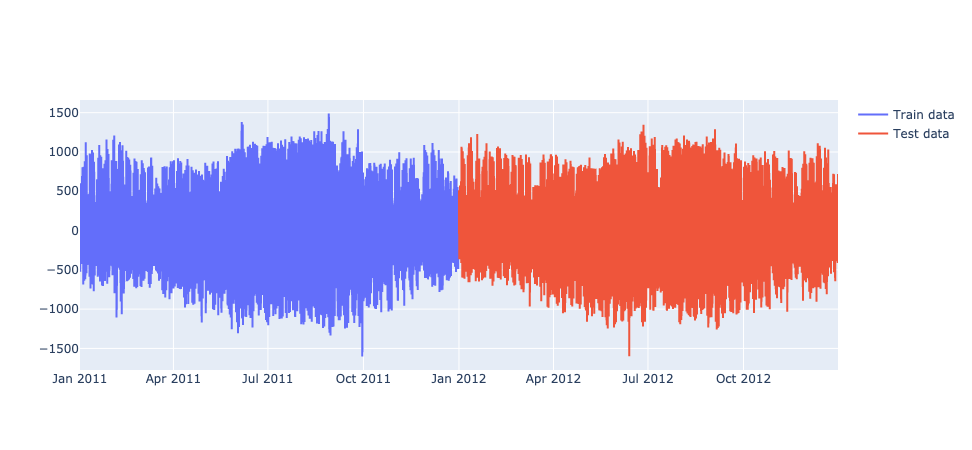

In [93]:
# show endogenous data

train_trace = go.Scatter(x=endogenous_train.index, y=endogenous_train, name='Train data')
test_trace = go.Scatter(x=endogenous_test.index, y=endogenous_test, name='Test data')
fig = go.Figure([train_trace, test_trace])
fig.show()

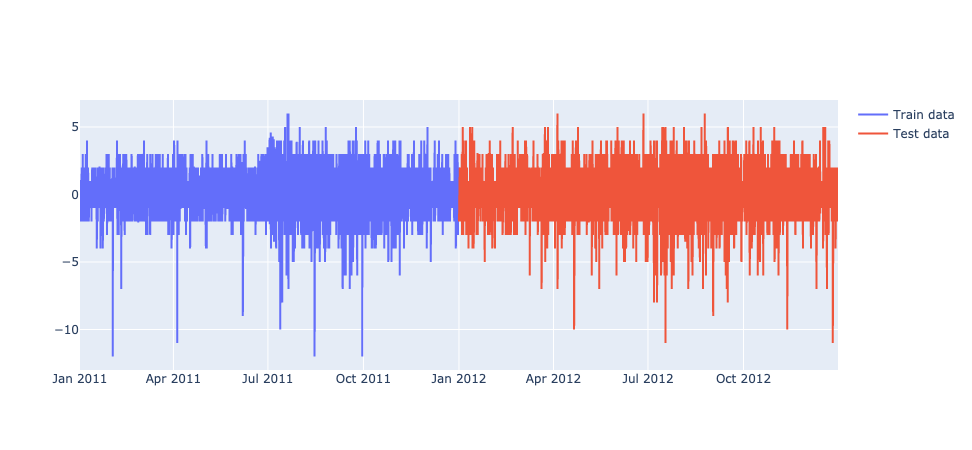

In [94]:
# show exogenous data

train_trace = go.Scatter(x=exogenous_train.index, y=exogenous_train['exogenous'], name='Train data')
test_trace = go.Scatter(x=exogenous_test.index, y=exogenous_test['exogenous'], name='Test data')
fig = go.Figure([train_trace, test_trace])
fig.show()

# 2. XGBoost & Linear Regression

In [29]:
# XGBoost default hyperparameters, train and predict

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror')
xg_reg.fit(exogenous_train, pd.DataFrame(data=endogenous_train))
xgb_preds = pd.Series(data=xg_reg.predict(exogenous_test), index=endogenous_test.index)

In [30]:
# Linear regression, train and predict

lreg = LinearRegression().fit(exogenous_train, endogenous_train)
lreg_preds = pd.Series(data=lreg.predict(exogenous_test), index=endogenous_test.index)

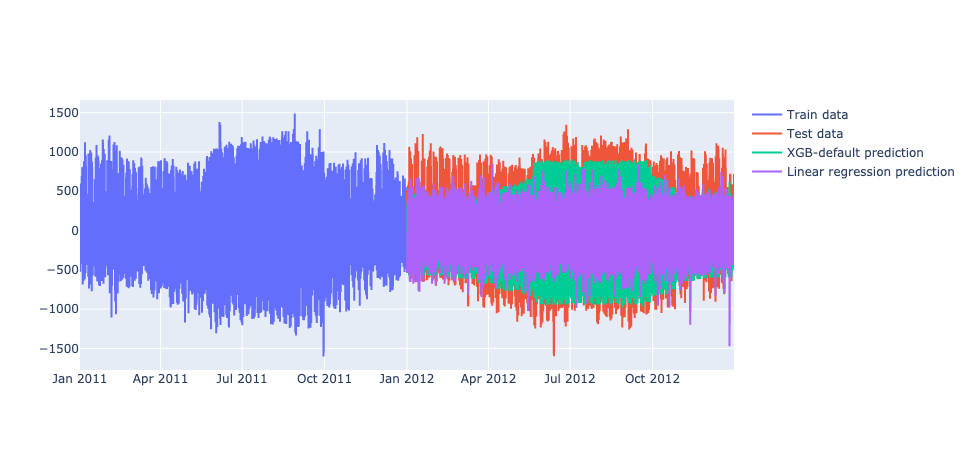

In [35]:
# Show predictions

train_trace = go.Scatter(x=endogenous_train.index, y=endogenous_train, name='Train data')
test_trace = go.Scatter(x=endogenous_test.index, y=endogenous_test, name='Test data')
xgb_pred_trace = go.Scatter(x=xgb_preds.index, y=xgb_preds, name='XGB-default prediction')
lreg_pred_trace = go.Scatter(x=lreg_preds.index, y=lreg_preds, name='Linear regression prediction')
fig = go.Figure([train_trace, test_trace, xgb_pred_trace, lreg_pred_trace])
fig.show()

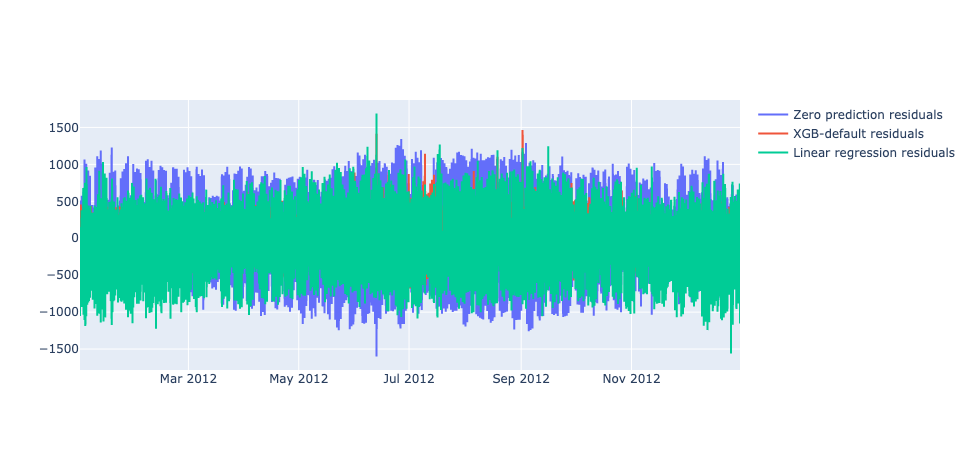

In [36]:
# show residuals

xgb_residuals = xgb_preds-endogenous_test
lreg_residuals = lreg_preds-endogenous_test
test_trace = go.Scatter(x=endogenous_test.index, y=endogenous_test, name='Zero prediction residuals')
xgb_res_trace = go.Scatter(x=endogenous_test.index, y=xgb_residuals, name='XGB-default residuals')
lreg_res_trace = go.Scatter(x=endogenous_test.index, y=lreg_residuals, name='Linear regression residuals')
fig = go.Figure([test_trace, xgb_res_trace, lreg_res_trace])
fig.show()

In [37]:
# Compare performance, measured in mean absolute error

print('Linear regression MAE: ' + str(mean_absolute_error(lreg_preds, y_test)))
print('XGB-default MAE: ' + str(mean_absolute_error(xgb_preds, y_test)))
print('Zero prediction MAE: ' + str(mean_absolute_error(y_test, pd.Series(data=np.zeros(len(y_test)), index=y_test.index))))

Linear regression MAE: 317.6054495222263
XGB-default MAE: 150.853200377163
Zero prediction MAE: 385.8120195340451


# 3. Hyperparameter optimization XGBoost with Bayesian optimization

Note: in the thesis experiment I added another crossvalidation dataset, in order to prevent overfitting on the test data during hyperparameter optimization

In [55]:
# objective function and search space for Bayesian optimization

def objective(params):
    
    # instantiate model with hyperparameters
    xg_reg = xgb.XGBRegressor(
        objective ='reg:squarederror',
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        n_estimators=int(params['n_estimators']),
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample']
    )
    
    # fit the model
    xg_reg.fit(exogenous_train,pd.DataFrame(data=endogenous_train, index=endogenous_train.index))
    
    # make predictions
    xgb_preds = pd.Series(data=xg_reg.predict(exogenous_test), index=endogenous_test.index)
    
    # performance metric
    result = mean_absolute_error(xgb_preds, endogenous_test)
    
    return {'loss': result, 'status': STATUS_OK}
search_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 800, 1),
    'max_depth':  hp.quniform('max_depth', 5, 20, 1),
    'min_child_weight': hp.quniform('min_child_weight', 5, 40, 1),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'learning_rate': hp.loguniform('learning_rate', -2.5, -0.5),
}
trials = Trials()

In [56]:
# Perform Bayesian optimization to find optimal hyperparameters

best = fmin(
    fn = objective,
    space = search_space,
    algo=tpe.suggest,
    max_evals = 100,
    trials=trials
)

100%|██████████| 100/100 [06:02<00:00,  3.62s/it, best loss: 116.98788105994628]


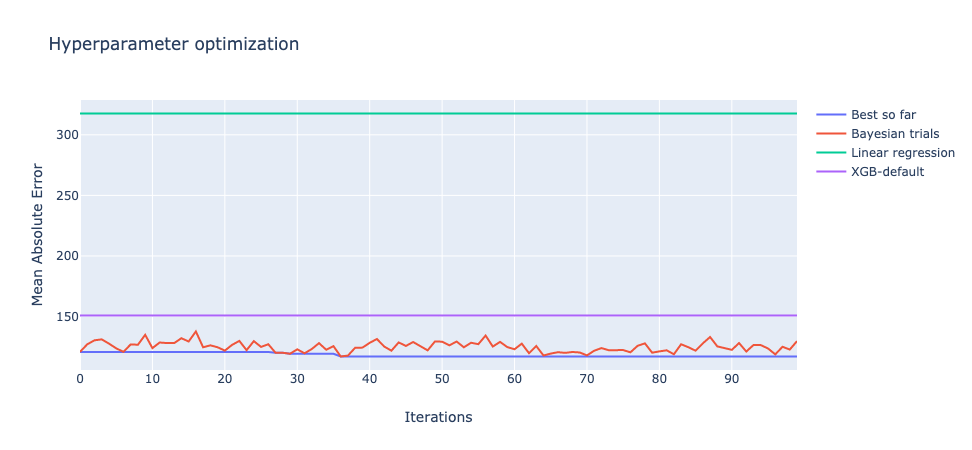

In [57]:
# Visualize Bayesian optimization process

perf_list = [trial['result']['loss'] for trial in trials.trials]
pending_min = [np.amin(perf_list[:i+1]) for i in range(len(perf_list))]
lreg_trace = go.Scatter(y=np.ones(len(perf_list))*mean_absolute_error(lreg_preds, y_test), name='Linear regression')
xgb_trace = go.Scatter(y=np.ones(len(perf_list))*mean_absolute_error(xgb_preds, y_test), name='XGB-default')
best_trace = go.Scatter(y=pending_min, name='Best so far')
bay_trace = go.Scatter(y=perf_list, name='Bayesian trials')
fig = go.Figure([best_trace, bay_trace, lreg_trace, xgb_trace])
fig.update_layout(title='Hyperparameter optimization',xaxis=go.layout.XAxis(title='Iterations'),yaxis=go.layout.YAxis(title="Mean Absolute Error"))
fig.show()

# 4. Warmstarted Bayesian optimization

In [3]:
# Get optimal hyperparameter settings of similar dataset and set them as warmstart configurations

sim_df = pd.read_csv('../../data/metadata/raw/WEST_diff_8760.csv', index_col=0, header=[1])
sorted_df = sim_df.sort_values(by=['mae'])
configs = []
for i in range(2):
    config = sorted_df.iloc[i][['max_depth','learning_rate','num_trees','min_child_weight','subsample']].to_dict()
    config['n_estimators'] = config.pop('num_trees')
    print(config)
    configs.append(config)
    
warmstart_trials = warmstart(configs)

{'max_depth': 9.0, 'learning_rate': 0.008799225435691074, 'min_child_weight': 5.0, 'subsample': 0.5, 'n_estimators': 380.0}
{'max_depth': 9.0, 'learning_rate': 0.014677992676220691, 'min_child_weight': 5.0, 'subsample': 0.5, 'n_estimators': 240.0}


NameError: name 'warmstart' is not defined

### Perform warmstarted Bayesian optimization

In [59]:
max_evals = 100
best = fmin(
    fn = objective,
    space = search_space,
    algo=tpe.suggest,
    max_evals = max_evals-len(configs),
    trials=warmstart_trials
)

100%|██████████| 100/100 [07:18<00:00,  4.38s/it, best loss: 115.34170564691247]


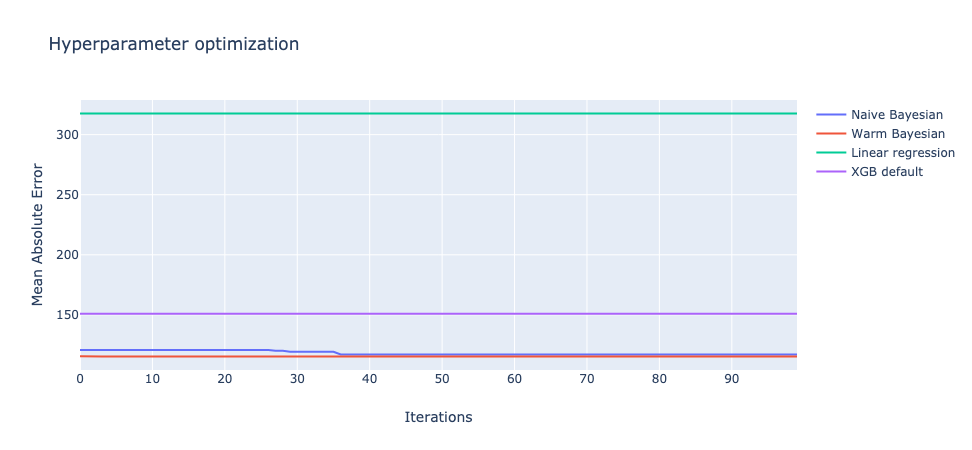

In [95]:
# Show Bayesian optimization results

naive_perf_list = [trial['result']['loss'] for trial in trials.trials]
naive_pending_min = [np.amin(naive_perf_list[:i+1]) for i in range(len(naive_perf_list))]
warm_perf_list = [trial['result']['loss'] for trial in warmstart_trials.trials]
warm_pending_min = [np.amin(warm_perf_list[:i+1]) for i in range(len(warm_perf_list))]

lreg_trace = go.Scatter(y=np.ones(len(warm_perf_list))*mean_absolute_error(lreg_preds, y_test), name='Linear regression')
xgb_trace = go.Scatter(y=np.ones(len(warm_perf_list))*mean_absolute_error(xgb_preds, y_test), name='XGB default')
naive_trace = go.Scatter(y=naive_pending_min, name='Naive Bayesian')
warm_trace = go.Scatter(y=warm_pending_min, name='Warm Bayesian')
fig = go.Figure([naive_trace, warm_trace, lreg_trace, xgb_trace])
fig.update_layout(title='Hyperparameter optimization',xaxis=go.layout.XAxis(title='Iterations'),yaxis=go.layout.YAxis(title="Mean Absolute Error"))
fig.show()